In [481]:
def get_all_supersingular_fp_curves(p):
    Fp = GF(p)
    Fp_curves = []
    for A in range(0, p):
        for B in range(0, p):
            try:
                E = EllipticCurve(Fp, [A, B])
                if E.is_supersingular():
                    Fp_curves.append(E)
            except:
                pass
    return Fp_curves

def get_all_supersingular_fp_curve_classes(p):
    Fp_curves = get_all_supersingular_fp_curves(p)
    Fp_curves_up_to_isomorphism = []
    for E in Fp_curves:
        added = False
        for arr in Fp_curves_up_to_isomorphism:
            E0 = arr[0]
            if E0.is_isomorphic(E):
                arr.append(E)
                added = True
                break
        if not added:
            Fp_curves_up_to_isomorphism.append([E])
    return Fp_curves_up_to_isomorphism

In [483]:
Fp_curves_up_to_isomorphism = get_all_supersingular_fp_curve_classes(419)
representative_curves = [arr[0] for arr in Fp_curves_up_to_isomorphism]

In [484]:
# Check every j-invariants appear twice
len(list(set([E.j_invariant() for E in representative_curves])))

18

In [485]:
# Get all directed edges between Fp curves
ells = [3, 5, 7]
directed_edges = []
for ell in ells:
    for Eidx in range(0, len(representative_curves)):
        E = representative_curves[Eidx]
        for varphi in E.isogenies_prime_degree(ell):
            E2 = varphi.codomain()
            found_codomain = False
            for Etestidx in range(0, len(representative_curves)):
                Etest = representative_curves[Etestidx]
                if E2.is_isomorphic(Etest):
                    directed_edges.append((Eidx, Etestidx, ell))
                    found_codomain = True
                    break
            if not found_codomain:
                raise Exception("Couldn't find codomain")


In [486]:
# Attempt to pair the edges
# Self-dual self loop appears as an edge
# 2 multi-edges sharing dual appear as 2 edges
undirected_edges = []
remaining_edges = copy(directed_edges)
while len(remaining_edges) > 0:
    (a,b,c) = remaining_edges[0]
    undirected_edges.append((a,b,c))
    remaining_edges.remove((a,b,c))
    remaining_edges.remove((b,a,c))

In [463]:
G_dir = DiGraph([list(range(0, len(representative_curves))), directed_edges])
G_undir = Graph([list(range(0, len(representative_curves))), undirected_edges])

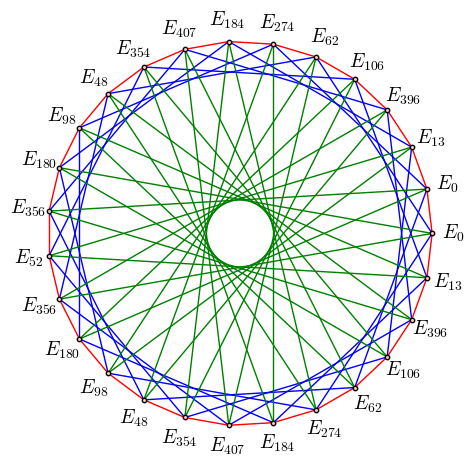

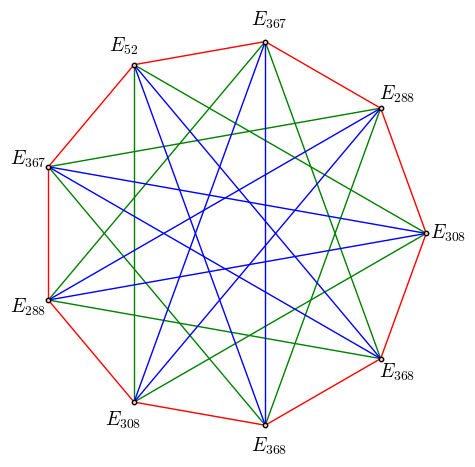

In [507]:
# Step 5 - Draw the graph
# We attempt to do this in a clever way for each connected component of the graph,
# pick the first l, take the cycles of the l volcano rim and put them into separate lists,
# then order vertices in the connected component by taking one vertex from each cycle, then a second vertex from each cycle,
# gradually moving around all cycles in parallel.

include_edges = ells   # Use this to filter edges
transparent_background = True

def colors_from_L(L):
    L_copy = copy(L)
    while len(L_copy) < 3:
        L_copy.append(0)
    return {L_copy[0]: "red", L_copy[1]: "green", L_copy[2]: "blue"}

def order_cycle_vertices(G, v):
    arr = [v]
    cur_v = v
    while True:
        nbs = G.neighbors(cur_v)
        valid_nbs = [v for v in nbs if v not in arr]
        if len(valid_nbs) == 0:
            break
        cur_v = valid_nbs[0]
        arr.append(cur_v)
    return arr

def interchange_order(lists, offsets=None):
    arr = []
    total_len = sum([len(arr) for arr in lists])
    idx1 = 0
    idx2 = 0
    while len(arr) < total_len:
        if offsets == None:
            arr.append(lists[idx1][idx2])
        else:
            arr.append(lists[idx1][mod(idx2 + offsets[idx1], len(lists[idx1]))])
        idx1 += 1
        if idx1 == len(lists):
            idx1 = 0
            idx2 += 1
    return arr

def circle_plot(G, vertex_order):
    textratio = 1.11
    yoffset = 0.05
    G = G.subgraph(vertex_order)
    angle_per_vertex = (2*pi) / len(vertex_order)
    pos = {k: [float(cos(vertex_order.index(k)*angle_per_vertex)), float(sin(vertex_order.index(k)*angle_per_vertex))] for k in G.vertices()}
    plot = G.graphplot(edge_colors=G._color_by_label(colors_from_L(ells)), vertex_size=10, vertex_labels=False, pos=pos)
    textobj = [text("$E_{" + str(labels[k]).replace("*", "") + "}$", (float(textratio*cos(vertex_order.index(k)*angle_per_vertex)), float(textratio*sin(vertex_order.index(k)*angle_per_vertex))), axes=False, color="black", fontsize=14)   for k in G.vertices()]
    # textobj += [text("$" + str("j").replace("*", "") + "$", (float(textratio*cos(vertex_order.index(k)*angle_per_vertex)), -yoffset + float(textratio*sin(vertex_order.index(k)*angle_per_vertex))), axes=False, color="black", fontsize=8)   for k in G.vertices()]
    return plot, sum(textobj)

# Use the second prime here as the result looks better
l1 = ells[0]

graph_vertices = list(range(0, len(representative_curves)))
graph_edges = undirected_edges
G = Graph([graph_vertices, graph_edges])
labels = [E.j_invariant() for E in representative_curves]

# G = Graph([graph_vertices, [e for e in graph_edges if e[2] in include_edges]], loops = True, multiedges=True)

for CC in G.connected_components():
    CC_vs = [v for v in graph_vertices if v in CC]
    CC_es = [e for e in graph_edges if e[0] in CC]
    G2 = Graph([CC_vs, CC_es], loops = True, multiedges=True)
    G2_l1 = Graph([
        CC_vs,
        [e for e in CC_es if e[2] == l1]
        ], loops = True, multiedges=True)
    arrs = [order_cycle_vertices(G2_l1, G2_CC[0]) for G2_CC in G2_l1.connected_components()]
    
    # We change the offsets here to make it look better
    v_ordered = interchange_order(arrs, [0, 0])

    # Alternatively do
    # v_ordered = interchange_order(arrs)

    r1, r2 = circle_plot(G2, v_ordered)
    (r1.plot(transparent=transparent_background) + r2).show()